In [1]:
import pandas as pd
import dask as dd
import numpy as np
from matplotlib import pyplot as plt
import wrds
import os
from statsmodels.sandbox.regression import gmm

In [2]:
# Import data

def request_wrds(path: str,
                 start_date: pd.Period,
                 end_date: pd.Period) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    with wrds.Connection() as db:
        df_s12 = db.raw_sql(f'''
            SELECT *
            FROM tfn.s12
            WHERE fdate >= '{start_date}' AND fdate <= '{end_date}'
        ''', date_cols=['fdate'])
        df_s12.to_csv(f'{path}s12.csv')

        df_s34 = db.raw_sql(f'''
            SELECT *
            FROM tfn.s34
            WHERE fdate >= '{start_date}' AND fdate <= '{end_date}'
        ''', date_cols=['fdate'])
        df_s34.to_csv(f'{path}s34.csv')

        df_security = db.raw_sql(f'''
            SELECT *
            FROM ff.factors_monthly
            WHERE date >= '{start_date}' AND date <= '{end_date}'
        ''', date_cols=['date'])
        df_security.to_csv(f'{path}security.csv')

        return df_s12, df_s34, df_security


def load_wrds(path: str,
              start_date: pd.Period,
              end_date: pd.Period
              ) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame):
    try:
        df_s12 = pd.read_csv(f'{path}s12.csv', encoding='ISO-8859-1', low_memory=False)
        log_import_s12(df_s12)

        df_s12type5 = pd.read_csv(f'{path}s12type5.csv', encoding='ISO-8859-1', low_memory=False)
        log_import_s12type5(df_s12type5)

        df_s34 = pd.read_csv(f'{path}s34.csv', encoding='ISO-8859-1', low_memory=False)
        log_import_s34(df_s34)

        df_beta = pd.read_csv(f'{path}beta.csv', encoding='ISO-8859-1', low_memory=False)
        log_import_beta(df_beta)

        df_security = pd.read_csv(f'{path}security.csv', encoding='ISO-8859-1', low_memory=False)
        log_import_security(df_security)

        return df_s12, df_s12type5, df_s34, df_beta, df_security
    except FileNotFoundError:
        return request_wrds(path, start_date, end_date)


def clean_imports(df_s12,
                  df_s12type5,
                  df_s34,
                  df_beta,
                  df_security,
                  start_date,
                  end_date
                  ) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame):

    df_s12_clean = clean_s12(df_s12, start_date, end_date)
    log_clean_s12(df_s12_clean)

    df_s12type5_clean = clean_s12type5(df_s12type5, start_date, end_date)
    log_clean_s12type5(df_s12type5_clean)

    df_s34_clean = clean_s34(df_s34, start_date, end_date)
    log_clean_s34(df_s34_clean)

    df_beta_clean = clean_beta(df_beta, start_date, end_date)
    log_clean_beta(df_beta_clean)

    df_security_clean = clean_security(df_security, start_date, end_date)
    log_clean_security(df_security_clean)

    return df_s12_clean, df_s12type5_clean, df_s34_clean, df_beta_clean, df_security_clean


def clean_s12(df: pd.DataFrame, start_date: pd.Period, end_date: pd.Period) -> pd.DataFrame:
    columns = [
        'fundno',
        'rdate',
        'cusip',
        'shares'
    ]
    df['rdate'] = df['rdate'].apply(fix_date, args=(start_date, end_date))
    return (df[columns]
            .dropna(how='any', subset=['fundno', 'shares', 'cusip'])
            .drop_duplicates(subset=['fundno', 'rdate', 'cusip'], keep='last')
            .rename(columns={
                'rdate': 'date',
                'fundno': 'inv_id',
                'cusip': 'asset_id'
            })
            .set_index(['inv_id', 'date', 'asset_id']))


def clean_s12type5(df: pd.DataFrame, start_date: pd.Period, end_date: pd.Period) -> pd.DataFrame:
    return (df
            .assign(fdate=df['fdate'].apply(fix_date, args=(start_date, end_date)))
            .dropna(how='any', subset=['fundno', 'fdate'])
            .rename(columns={'fdate': 'date', 'fundno': 'inv_id'})
            .set_index(['inv_id', 'date']))


def clean_s34(df: pd.DataFrame, start_date: pd.Period, end_date: pd.Period) -> pd.DataFrame:
    columns = [
        'mgrno',
        'rdate',
        'typecode',
        'cusip',
        'shares',
        'backup_holding',
        'backup_me'
    ]
    df['rdate'] = df['rdate'].apply(fix_date, args=(start_date, end_date))
    df['backup_holding'] = df['shares'] * df['prc']
    df['backup_me'] = df['shrout2'] * df['prc'] * 1000
    return (df[columns]
            .dropna(how='any', subset=['cusip', 'shares'])
            .drop_duplicates(subset=['mgrno', 'rdate', 'cusip'])
            .rename(columns={
                'rdate': 'date',
                'mgrno': 'inv_id',
                'cusip': 'asset_id'
            })
            .set_index(['inv_id', 'date', 'asset_id']))


def clean_beta(df: pd.DataFrame, start_date: pd.Period, end_date: pd.Period) -> pd.DataFrame:
    columns=[
        'PERMNO',
        'DATE',
        'b_mkt',
        'b_smb',
        'b_hml'
    ]
    df['DATE'] = df['DATE'].apply(fix_date, args=(start_date, end_date)) + 6
    return (df[columns]
            .rename(columns={
                'DATE': 'date',
                'PERMNO':'permno'})
            .dropna()
            .drop_duplicates(subset=['date', 'permno'], keep='last')
            .set_index(['date', 'permno']))


def clean_security(df: pd.DataFrame, start_date: pd.Period, end_date: pd.Period) -> pd.DataFrame:
    columns = [
        'LPERMNO',
        'cusip',
        'datadate',
        'prccm',
        'cshoq'
    ]
    return (df[columns]
            .rename(columns={
                'LPERMNO': 'permno',
                'cusip': 'asset_id',
                'prccm': 'prc',
                'cshoq': 'shrout',
                'datadate': 'date'})
            .assign(
                shrout=df['cshoq'] * 1000000,
                asset_id=df['cusip'].apply(lambda  x: x[:-1]),
                date=df['datadate'].apply(fix_date, args=(start_date, end_date)))
            .dropna(how='any', subset=['asset_id', 'prc', 'shrout'])
            .drop_duplicates(subset=['date', 'permno'], keep='last')
            .set_index(['date', 'permno']))


def fix_date(date: str, start_date: pd.Period, end_date: pd.Period) -> pd.Period:
    date_converted = pd.Period(date, freq='M')

    if date_converted < start_date or date_converted > end_date:
        return np.NaN
    else:
        return date_converted

In [3]:
# Stocks Monthly

def merge_assets_factors(df_assets: pd.DataFrame, df_factors: pd.DataFrame) -> pd.DataFrame:
    df_merged = pd.merge(left=df_assets,
                      right=df_factors,
                      how='inner',
                      left_index=True,
                      right_index=True)
    df_merged_indexed = (df_merged
                         .reset_index()
                         .assign(date=lambda x: x['date'].astype(pd.PeriodDtype('Q')))
                         .drop_duplicates(subset=['date', 'asset_id'], keep='last')
                         .set_index(['date', 'asset_id']))
    log_asset_merge(df_merged_indexed)
    return df_merged_indexed


# Manager / Holdings

def match_fund_manager(df_fund: pd.DataFrame, df_manager: pd.DataFrame, df_key: pd.DataFrame) -> pd.DataFrame:
    # TODO
    # df_fund_wkey = df_fund.assign(mgrno=lambda x: df_key.loc[x.index.get_level_values(0), 'mgrcocd'])
    # df_merged = df_manager.merge(df_fund_wkey, how='outer', on='mgrno')
    
    df_fund_manager = (df_manager
                       .reset_index()
                       .assign(date=lambda x: x['date'].astype(pd.PeriodDtype('Q')))
                       .drop_duplicates(subset=['inv_id', 'date', 'asset_id'], keep='last')
                       .set_index(['inv_id', 'date', 'asset_id']))
    log_holding_merge(df_fund_manager)
    return df_fund_manager


def merge_holding_factor(df_holding: pd.DataFrame, df_asset: pd.DataFrame) -> pd.DataFrame:
    df_merged = pd.merge(
        left=df_holding,
        right=df_asset,
        how='left',
        left_index=True,
        right_index=True,
        indicator=True
    )

    df_merged = (df_merged
                 .assign(
                   ccm_holding=lambda x: x['prc'] * x['shares'],
                   ccm_me=lambda x: x['prc'] * x['shrout'],
                   holding=lambda x: x['ccm_holding'].fillna(x['backup_holding']) / 1000000,
                   me=lambda x: x['ccm_me'].fillna(x['backup_me']) / 1000000,
                   type_code=lambda x: x['typecode'].fillna(0))
                 .drop(columns=['ccm_holding', 'backup_holding', 'ccm_me', 'backup_me'])
                 .dropna(subset=['holding'])
                 .reset_index()
                 .astype({'inv_id': 'str', 'type_code': 'int'})
                 .set_index(['inv_id', 'date', 'asset_id'])
                 .sort_index())
    log_holding_factor_merge(df_merged)
    return df_merged


def create_outside_asset(df_holding_factor: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    df_inside = df_holding_factor[df_holding_factor['_merge'] == 'both'].drop(columns='_merge')
    df_outside = df_holding_factor[df_holding_factor['_merge'] == 'left_only'].groupby(['inv_id', 'date']).agg({
        'typecode': 'first',
        'holding': 'sum'
    }).assign(asset_id='-1').set_index('asset_id', append=True)
    log_outside_asset(df_outside)
    return df_inside, df_outside


def assetid_byinv(df_holding: pd.DataFrame) -> pd.Series:
    return df_holding.reset_index('asset_id')['asset_id']


def create_household_sector(df_outside: pd.DataFrame) -> pd.DataFrame:
    df_household = (df_outside
                      .groupby(['date', 'asset_id'])
                      .agg({
                        'shares': 'sum',
                        'prc': 'last',
                        'shrout': 'last',
                        'b_mkt': 'last',
                        'b_smb': 'last',
                        'b_hml': 'last',
                        'holding': 'sum',
                        'me': 'last'})
                      .assign(
                        shares=lambda x: x['shrout'] - x['shares'],
                        holding=lambda x: x['me'] - x['holding'],
                        inv_id='0',
                        typecode=-10)
                    .set_index('inv_id', append=True)
                    .reorder_levels(['inv_id', 'date', 'asset_id']))
    log_household_sector(df_household)
    return df_household

In [4]:
# Data

def calc_inv_aum(df_inside: pd.DataFrame, df_outside: pd.DataFrame) -> pd.DataFrame:
    df_in_aum = (df_inside
                 .groupby(['inv_id', 'date'])
                 .agg({
                   'holding': 'sum',
                   'shares': 'count',
                   'typecode': 'last'})
                 .rename(columns={
                   'holding': 'in_aum',
                   'shares': 'n_holding'}))

    df_out_aum = (df_outside
                  .groupby(['inv_id', 'date'])
                  .agg({
                    'holding': 'sum',
                    'typecode': 'last'})
                  .rename(columns={'holding': 'out_aum'}))

    df_merged = pd.merge(
        left=df_in_aum,
        right=df_out_aum,
        how='outer',
        left_index=True,
        right_index=True)
    
    df_inv_aum = (df_merged
                  .assign(
                    typecode=lambda x: x['typecode_x'].fillna(x['typecode_y']),
                    n_holding=lambda x: x['n_holding'].fillna(0),
                    out_aum=lambda x: x['out_aum'].fillna(0),
                    in_aum=lambda x: x['in_aum'].fillna(0),
                    aum=lambda x: x['out_aum'] + x['in_aum'])
                  .drop(columns=['typecode_x', 'typecode_y']))

    log_inv_aum(df_inv_aum)
    return df_inv_aum


def bin_concentrated_inv(df_inside: pd.DataFrame, df_inv_aum: pd.DataFrame, min_n_holding: int) -> (pd.DataFrame, pd.DataFrame):
    household_mask = (df_inv_aum['out_aum'] == 0) | (df_inv_aum['in_aum'] == 0)
    df_valid = df_inv_aum[~household_mask]
    
    diversified_mask = df_valid['n_holding'] >= min_n_holding
    df_aum_diversified = df_valid[diversified_mask]
    df_aum_concentrated = df_valid[~diversified_mask].assign(bin=np.nan)
    
    arr_dates = df_aum_concentrated.index.get_level_values('date')
    arr_unique_dates = arr_dates.unique()
    arr_typecodes = df_aum_concentrated['typecode'].unique()
    
    for date in arr_unique_dates:
        for typecode in arr_typecodes:
            mask = (arr_dates == date) & (df_aum_concentrated['typecode'] == typecode)
            df_type_date = df_aum_concentrated[mask]
            n_bins = np.ceil(df_type_date['n_holding'].sum() / (2 * min_n_holding)).astype(int)
            if n_bins <= 1:
                df_aum_concentrated.loc[mask, 'bin'] = 0
            else:
                df_aum_concentrated.loc[mask, 'bin'] = pd.qcut(x=df_type_date['aum'], q=n_bins, labels=False).astype(int)

    df_aum_concentrated = (df_aum_concentrated
                           .astype({'bin':'str'})
                           .assign(bin=lambda x: x['typecode'].astype('str') + ':' + x['bin']))
    df_concentrated_binned = (df_aum_concentrated
                              .reset_index()
                              .groupby(['bin', 'date'])
                              .agg({
                                'in_aum': 'sum',
                                'out_aum': 'sum',
                                'aum': 'sum',
                                'n_holding': 'sum',
                                'typecode': 'last'})
                              .rename_axis(index={'bin': 'inv_id'}))
    df_aum_binned = (pd.concat([df_aum_diversified, df_concentrated_binned])
                     .sort_index()
                     .assign(
                       out_weight=lambda x: x['out_aum'] / x['aum'],
                       in_weight=lambda x: x['in_aum'] / x['aum']))

    df_inside_merged = pd.merge(
        left=df_inside,
        right=df_aum_concentrated['bin'],
        how='left',
        left_index=True,
        right_index=True)
    df_inside_binned = (df_inside_merged
                        .reset_index()
                        .assign(bin=lambda x: x['bin'].fillna(x['inv_id']))
                        .groupby(['bin', 'date', 'asset_id'])
                        .agg({
                          'holding': 'sum',
                          'prc': 'last',
                          'shrout': 'last',
                          'me': 'last',
                          'b_mkt': 'last',
                          'b_smb': 'last',
                          'b_hml': 'last'})
                        .rename_axis(index={'bin': 'inv_id'}))
    
    log_bins(df_inside_binned, df_aum_binned)
    return df_inside_binned, df_aum_binned


def calc_inv_universe(df_holding: pd.DataFrame, n_quarters: int) -> pd.DataFrame:
    df_assetid_byinv = assetid_byinv(df_holding).sort_index()
    idx_inv_universe = df_assetid_byinv.index.unique()
    df_inv_universe = pd.DataFrame(index=idx_inv_universe, columns=['inv_universe'])

    def calc_past_quarters(i: int, d: pd.Period) -> np.array:
        prev_date = d - n_quarters
        asset_id_within_range = df_assetid_byinv.loc[i].loc[prev_date:d]
        inv_uni = asset_id_within_range.unique().tolist()
        return inv_uni

    for (inv_id, date) in idx_inv_universe.to_flat_index():
        inv_uni = calc_past_quarters(inv_id, date)
        df_inv_universe.loc[(inv_id, date), 'inv_universe'] = inv_uni

    df_inv_universe = df_inv_universe.assign(uni_size=lambda x: x['inv_universe'].apply(len))
    log_inv_universe(df_inv_universe)
    return df_inv_universe


def create_equal_allocation(df_inv_universe: pd.DataFrame, df_aum_binned: pd.DataFrame) -> pd.DataFrame:
    df_equal_alloc = pd.merge(
        left=df_inv_universe,
        right=df_aum_binned,
        how='inner',
        left_index=True,
        right_index=True)
    
    return (df_equal_alloc
            .assign(allocation=lambda x: x['aum'] / (x['uni_size'] + 1))
            .explode('inv_universe')
            .rename(columns={'inv_universe':'asset_id'})
            .set_index('asset_id', append=True))


def create_total_allocation(df: pd.DataFrame) -> pd.DataFrame:
    return (df['allocation']
            .groupby('asset_id')
            .sum())


def create_instrument(df_inv_universe: pd.DataFrame, df_aum_binned: pd.DataFrame) -> pd.DataFrame:
    df_equal_allocation = create_equal_allocation(df_inv_universe, df_aum_binned)
    total_allocation = create_total_allocation(df_equal_allocation)
    df_instrument = df_equal_allocation.assign(iv_me=lambda x: total_allocation - x['allocation'])
    log_instrument(df_instrument)
    return df_instrument

In [222]:
# Estimation

def calc_holding_weights(df_instrument: pd.DataFrame, df_inside_binned: pd.DataFrame, min_holding: int) -> pd.DataFrame:
    df_merged = pd.merge(
        left=df_instrument,
        right=df_inside_binned,
        how='inner',
        left_index=True,
        right_index=True)
    
    mask = (df_merged['n_holding'] >= min_holding) & (df_merged['out_weight'] > 0) & (df_merged['in_weight'] > 0) & (df_merged['me'] > 0) & (df_merged['iv_me'] > 0)

    df_weights = (df_merged.loc[mask]
                 .assign(
                   ln_me=lambda x: np.log(x['me']),
                   ln_iv_me=lambda x: np.log(x['iv_me']),
                   weight=lambda x: x['holding'] / x['aum'],
                   ln_weight=lambda x: np.log(x['weight']),
                   rweight=lambda x: x['weight'] / x['out_weight'],
                   ln_rweight=lambda x: np.log(x['rweight']),
                   mean_ln_rweight=lambda x: x['ln_rweight'].groupby(['inv_id', 'date']).transform('mean'),
                   const=1)
                .reset_index('asset_id'))
    
    log_holding_weights(df_weights)
    return df_weights


def unpack_result(result: gmm.GMMResults) -> dict:
    return result.params


def momcond_1(params, exog):
    upper_bound = 0.999
    exog = exog.T
    
    beta_ln_me = params[0]
    beta_characteristics = params[1:]
    
    ln_me = exog[0]
    mean_ln_rweight = exog[1]
    arr_characteristics = exog[2:]
    
    ln_me_term = (upper_bound - np.exp(-1 * beta_ln_me)) * ln_me
    characteristics_term = np.dot(beta_characteristics, arr_characteristics)
    pred_weight = ln_me_term + characteristics_term + mean_ln_rweight
    
    return pred_weight


def momcond_2(params, exog):
    upper_bound = 0.999
    exog = exog.T
    
    beta_ln_me = params[0]
    beta_characteristics = params[1:]
    
    ln_me = exog[0]
    rweight = exog[1]
    mean_ln_rweight = exog[2]
    arr_characteristics = exog[3:]
    
    ln_me_term = (upper_bound - np.exp(-1 * beta_ln_me)) * ln_me
    characteristics_term = np.dot(beta_characteristics, arr_characteristics)
    pred_weight = np.exp(-1 * (ln_me_term + characteristics_term + mean_ln_rweight))
    
    return rweight * pred_weight


def estimate_model(df_weights: pd.DataFrame, characteristics: list, params: list) -> pd.DataFrame:
    
    def fit_inv_date_1(df_inv_date: pd.DataFrame) -> gmm.GMMResults:
        exog = np.asarray(df_inv_date[['ln_me', 'mean_ln_rweight'] + characteristics])
        instrument = np.asarray(df_inv_date[['ln_iv_me', 'mean_ln_rweight'] + characteristics])
        n = exog.shape[0]
        endog = np.asarray(df_inv_date['ln_rweight'])
        start_params = np.zeros(len(params))
        w0inv = np.dot(instrument.T, instrument) / n
        
        try:
            model = gmm.NonlinearIVGMM(
                endog=endog,
                exog=exog,
                instrument=instrument, 
                func=momcond_1)
            result = model.fit(
                start_params=start_params,
                maxiter=0,
                inv_weights=w0inv)
            log_results(result, params)
            return result
        except np.linalg.LinAlgError:
            print('Linear Algebra Error')
            print(f'Investor Id:  {df_inv_date.index.get_level_values(0).unique()}')
            print(f'Date:  {df_inv_date.index.get_level_values(1).unique()}')
            return np.NaN


    def fit_inv_date_2(df_inv_date: pd.DataFrame) -> gmm.GMMResults:
        exog = np.asarray(df_inv_date[['ln_me', 'rweight', 'mean_ln_rweight'] + characteristics], dtype=np.longdouble)
        instrument = np.asarray(df_inv_date[['ln_iv_me', 'rweight', 'mean_ln_rweight'] + characteristics], dtype=np.longdouble)
        n = exog.shape[0]
        endog = np.ones(n, dtype=np.longdouble)
        
        try:
            model = gmm.NonlinearIVGMM(
                endog=endog,
                exog=exog,
                instrument=instrument, 
                func=momcond_1)
            w0inv = np.dot(instrument.T, instrument) / n
            start_params = np.zeros(len(params))
            result = model.fit(
                start_params=start_params,
                maxiter=0,
                inv_weights=w0inv)
            log_results(result, params)
            return result
        except np.linalg.LinAlgError:
            print('Singular Matrix Error')
            print(f'Investor Id:  {df_inv_date.index.get_level_values(0).unique()}')
            print(f'Date:  {df_inv_date.index.get_level_values(1).unique()}')
            return np.NaN



    cols = [['ln_me', 'ln_iv_me', 'rweight', 'mean_ln_rweight'] + characteristics]
    df_model = df_weights.assign(
        gmm_result=lambda x: x.groupby(['inv_id', 'date']).apply(fit_inv_date_1),
        lst_params=lambda x: x['gmm_result'].apply(unpack_result))
    df_model[params] = pd.DataFrame(df_model['lst_params'].tolist(), index=df_model.index)
    df_model = df_model.drop(columns='lst_params')
    
    log_params(df_model)
    return df_model


def calc_latent_demand(df_model: pd.DataFrame, characteristics: list, params: list) -> pd.DataFrame:
    upper_bound = 0.999
    
    df_results = df_model.assign(
        beta_ln_me=lambda x: upper_bound - np.exp(-1 * x['beta_ln_me']),
        char_demand=lambda x: np.einsum('ij,ij->i', x[['ln_me'] + characteristics], x[params]),
        pred_rweight=lambda x: np.exp(-1 * (x['char_demand'] + x['mean_ln_rweight'])),
        latent_demand=lambda x: x['rweight'] * x['pred_rweight'])
    log_latent_demand(df_results)
    return df_results

In [201]:
# Figures

def j_test(df_results: pd.DataFrame):
    # TODO
    pass


def graph_index_params(df_results: pd.DataFrame):
    # TODO
    pass

def graph_type_params(df_results: pd.DataFrame, params: list, figure_path: str):
    cols = params + ['latent_demand']
    df_types = df_results.groupby(['typecode', 'date'])[cols].mean()
    
    for param in cols:
        df_types.groupby('typecode')[param].apply(lambda x: x.plot(label=dict_typecode[x.name]))
        plt.xlabel('Date')
        plt.ylabel(f'{get_readable_param(param)}')
        plt.legend()
        plt.savefig(os.path.join(figure_path, f'{param}.png'))
        plt.show()

    
def get_param_cols(cols: list) -> list:
    return ['beta_' + col for col in cols]


def get_readable_param(name: str) -> str:
    return name.replace('_', ' ').title()

In [83]:
# Log

def log_import_s12(df_s12: pd.DataFrame):
    dateindex_s12 = df_s12['rdate']
    print('Imported s12')
    print('Number of holdings:  ', len(df_s12))
    print('Earliest date:  ', min(dateindex_s12))
    print('Latest date:  ', max(dateindex_s12))


def log_import_s12type5(df_s12type5: pd.DataFrame):
    dateindex_s12type5 = df_s12type5['fdate']
    print()
    print('Imported s12type5')
    print('Number of holdings:  ', len(df_s12type5))
    print('Earliest date:  ', min(dateindex_s12type5))
    print('Latest date:  ', max(dateindex_s12type5))


def log_import_s34(df_s34: pd.DataFrame):
    dateindex_s34 = df_s34['rdate']
    print()
    print('Imported s34')
    print('Number of holdings:  ', len(df_s34))
    print('Earliest date:  ', min(dateindex_s34))
    print('Latest date:  ', max(dateindex_s34))


def log_import_beta(df_beta: pd.DataFrame):
    dateindex_ffm = df_beta['DATE']
    print()
    print('Imported betas')
    print('Number of dates:  ', len(df_beta))
    print('Earliest date:  ', min(dateindex_ffm))
    print('Latest date:  ', max(dateindex_ffm))


def log_import_security(df_security: pd.DataFrame):
    dateindex_security = df_security['datadate']
    print()
    print('Imported security')
    print('Number of holdings:  ', len(df_security))
    print('Earliest date:  ', min(dateindex_security))
    print('Latest date:  ', max(dateindex_security))


def log_clean_s12(df_s12_clean: pd.DataFrame):
    dateindex_s12 = df_s12_clean.index.get_level_values('date')
    print('Cleaned s12')
    print('Number of holdings:  ', len(df_s12_clean))
    print('Earliest date:  ', min(dateindex_s12))
    print('Latest date:  ', max(dateindex_s12))


def log_clean_s12type5(df_s12type5_clean: pd.DataFrame):
    dateindex_s12type5 = df_s12type5_clean.index.get_level_values('date')
    print()
    print('Cleaned s12type5')
    print('Number of firm/dates:  ', len(df_s12type5_clean))
    print('Earliest date:  ', min(dateindex_s12type5))
    print('Latest date:  ', max(dateindex_s12type5))


def log_clean_s34(df_s34_clean: pd.DataFrame):
    dateindex_s34 = df_s34_clean.index.get_level_values('date')
    print()
    print('Cleaned s34')
    print('Number of holdings:  ', len(df_s34_clean))
    print('Earliest date:  ', min(dateindex_s34))
    print('Latest date:  ', max(dateindex_s34))


def log_clean_beta(df_beta_clean: pd.DataFrame):
    dateindex_beta = df_beta_clean.index.get_level_values('date')
    print()
    print('Cleaned beta')
    print('Number of dates:  ', len(df_beta_clean))
    print('Earliest date:  ', min(dateindex_beta))
    print('Latest date:  ', max(dateindex_beta))


def log_clean_security(df_security_clean: pd.DataFrame):
    dateindex_security = df_security_clean.index.get_level_values('date')
    print()
    print('Cleaned security')
    print('Number of asset/dates:  ', len(df_security_clean))
    print('Earliest date:  ', min(dateindex_security))
    print('Latest date:  ', max(dateindex_security))


def log_holding_merge(df_merged: pd.DataFrame):
    print('Merged s12 and s34')
    print('Number of holdings:  ', len(df_merged))
    print()


def log_asset_merge(df_merged: pd.DataFrame):
    print('Merged assets and factors')
    print('Number of assets/dates:  ', len(df_merged))
    print()


def log_holding_factor_merge(df_merged: pd.DataFrame):
    print('Merged holdings and factors')
    print('Number of assets/dates:  ', len(df_merged))
    print()


def log_household_sector(df_household: pd.DataFrame):
    print('Created household sector')
    print('Number of holdings:  ', len(df_household))


def log_outside_asset(df_holding: pd.DataFrame):
    print('Created outside asset')
    print('Number of holdings:  ', len(df_holding))


def log_inv_aum(df_inv_aum: pd.DataFrame):
    print('Calculated investor AUM')
    print(df_inv_aum.describe())


def log_bins(df_inside_binned: pd.DataFrame, df_aum_binned: pd.DataFrame):
    print('Binned investors')
    print('Number of investors by aum:  ', len(df_inside_binned.index.unique('inv_id')))
    print('Number of investors by holding:  ', len(df_aum_binned.index.unique('inv_id')))


def log_inv_universe(df_inv_uni: pd.DataFrame):
    print('Created investment universe')
    print(df_inv_uni.describe())
    
    
def create_tables(df_instrument: pd.DataFrame, df_inv_uni: pd.DataFrame):
    df_pctile = df_inv_uni.assign(pctile=0)
    arr_dates = df_pctile.index.get_level_values('date').unique()
    
    for date in arr_dates:
        data = df_pctile.loc[date, 'aum']
        df_pctile.loc[date, 'pctile'] = pd.qcut(data, q=100)
        
    df_grouped_pctile = (df_pctile['uni_persistence']
                         .groupby(['pctile'])
                         .median())
    print(df_grouped_pctile.head(10))


def log_instrument(df_instrument: pd.DataFrame):
    print('Created market equity instrument')
    print(df_instrument.describe())
    print()
    

def log_holding_weights(df_model: pd.DataFrame):
    print('Calculated holding weights')
    print(df_model.describe())


def log_results(result, params):
    print(result.summary(yname='Latent demand', xname=params))
    print()
    

def log_params(df_params: pd.DataFrame):
    print('Estimated parameters')
    print()
    
    
def log_latent_demand(df_results: pd.DataFrame):
    print('Calculated latent demand')
    print()

In [207]:
# Global parameters

plt.style.use('seaborn-v0_8-bright')

input_path = 'data/'
output_path = 'output/'
figure_path = 'figures/'

start_date = pd.Period('2012-01', freq='M')
end_date = pd.Period('2017-12', freq='M')

characteristics = [
    'b_mkt', # can be changed
    'b_smb', # can be changed
    'b_hml'  # can be changed
] + ['const']
params = ['beta_ln_me'] + get_param_cols(characteristics)
dict_typecode = {
     0: 'Households',
     1: 'Banks',
     2: 'Insurance companies',
     3: 'Investment advisors',
     4: 'Mutual funds',
     5: 'Pension funds',
}

min_n_holding = 1000
n_quarters = 11

In [9]:
# Main

print('\n---------------Starting Imports---------------------------\n')
dfs = load_wrds(input_path, start_date, end_date)

print('\n---------------Starting Cleaning---------------------------\n')
df_s12_clean, df_s12type5_clean, df_s34_clean, df_beta_clean, df_security_clean = clean_imports(
    *dfs,
    start_date,
    end_date
)

df_s12_clean.to_csv(os.path.join(output_path, 'df_s12_clean.csv'))
df_s12type5_clean.to_csv(os.path.join(output_path, 'df_s12type5_clean.csv'))
df_s34_clean.to_csv(os.path.join(output_path, 'df_s34_clean.csv'))
df_beta_clean.to_csv(os.path.join(output_path, 'df_beta_clean.csv'))
df_security_clean.to_csv(os.path.join(output_path, 'df_security_clean.csv'))


---------------Starting Imports---------------------------

Imported s12
Number of holdings:   30987
Earliest date:   2014-06-30
Latest date:   2017-12-31

Imported s12type5
Number of holdings:   572518
Earliest date:   12/31/1994
Latest date:   9/30/2022

Imported s34
Number of holdings:   22707709
Earliest date:   2012-03-31
Latest date:   2017-12-31

Imported betas
Number of dates:   432458
Earliest date:   2012-01-31
Latest date:   2017-12-29

Imported security
Number of holdings:   402452
Earliest date:   2012-01-31
Latest date:   2017-12-31

---------------Starting Cleaning---------------------------
Cleaned s12
Number of holdings:   27327
Earliest date:   2014-06
Latest date:   2017-12

Cleaned s12type5
Number of firm/dates:   49372
Earliest date:   2012-03
Latest date:   2017-12

Cleaned s34
Number of holdings:   22267070
Earliest date:   2012-03
Latest date:   2017-12

Cleaned beta
Number of dates:   432414
Earliest date:   2012-07
Latest date:   2018-06

Cleaned security
Num

In [10]:
print('\n---------------Merging Assets/Factors---------------------------\n')
df_asset = merge_assets_factors(df_security_clean, df_beta_clean)
df_asset.to_csv(os.path.join(output_path, 'df_asset.csv'))

print('\n---------------Merging s12/s34 Holdings---------------------------\n')
df_fund_manager = match_fund_manager(df_s12_clean, df_s34_clean, df_s12type5_clean)
df_fund_manager.to_csv(os.path.join(output_path, 'df_fund_manager.csv'))


---------------Merging Assets/Factors---------------------------
Merged assets and factors
Number of assets/dates:   98918

---------------Merging s12/s34 Holdings---------------------------
Merged s12 and s34
Number of holdings:   22267070


In [20]:
print('\n---------------Merging Holdings/Factors---------------------------\n')
df_holding_factor = merge_holding_factor(df_fund_manager, df_asset)
df_holding_factor.to_csv(os.path.join(output_path, 'df_holding_factor.csv'))

print('\n---------------Partitioning Outside Asset---------------------------\n')
df_inside, df_outside = create_outside_asset(df_holding_factor)
df_inside.to_csv(os.path.join(output_path, 'df_inside.csv'))
df_outside.to_csv(os.path.join(output_path, 'df_outside.csv'))

print('\n---------------Creating Household Sector---------------------------\n')
df_household = create_household_sector(df_inside)
df_household.to_csv(os.path.join(output_path, 'df_household.csv'))

print('\n---------------Calculating Investor AUM---------------------------\n')
df_inv_aum = calc_inv_aum(df_inside, df_outside)
df_inv_aum.to_csv(os.path.join(output_path, 'df_inv_aum.csv'))


---------------Merging Holdings/Factors---------------------------
Merged holdings and factors
Number of assets/dates:   22243229

---------------Partitioning Outside Asset---------------------------
Created outside asset
Number of holdings:   90936

---------------Creating Household Sector---------------------------
Created household sector
Number of holdings:   75467

---------------Calculating Investor AUM---------------------------
Calculated investor AUM
             in_aum     n_holding       out_aum      typecode           aum
count  9.282700e+04  92827.000000  9.282700e+04  92824.000000  9.282700e+04
mean   3.520373e+09    163.105831  1.046345e+09      4.522149  4.566718e+09
std    2.915269e+10    351.706418  8.350515e+09      0.764381  3.438445e+10
min    0.000000e+00      0.000000  0.000000e+00      1.000000  1.552000e+01
25%    6.046979e+07     13.000000  3.739851e+07      4.000000  1.548055e+08
50%    1.947032e+08     52.000000  1.128732e+08      5.000000  3.607226e+08
75%

In [21]:
# df_inside = pd.read_csv(os.path.join(output, 'df_inside.csv'), dtype={'date':pd.PeriodDtype('Q')})
# df_inv_aum = pd.read_csv(os.path.join(output, 'df_inv_aum.csv'), dtype={'date':pd.PeriodDtype('Q')})
# df_outside = pd.read_csv(os.path.join(output, 'df_outside.csv'), dtype={'date':pd.PeriodDtype('Q')})
# df_asset = pd.read_csv(os.path.join(output, 'df_asset.csv'), dtype={'date':pd.PeriodDtype('Q')})
# 
# df_inside.set_index(['inv_id', 'date', 'asset_id'], inplace=True)
# df_inv_aum.set_index(['inv_id', 'date'], inplace=True)
# df_outside.set_index(['inv_id', 'date', 'asset_id'], inplace=True)
# df_asset.set_index(['date', 'asset_id'], inplace=True)

In [22]:
print('\n---------------Pooling Investors By Type/Size---------------------------\n')
df_inside_binned, df_aum_binned = bin_concentrated_inv(df_inside, df_inv_aum, min_n_holding)
df_inside_binned.to_csv(os.path.join(output_path, 'df_inside_binned.csv'))
df_aum_binned.to_csv(os.path.join(output_path, 'df_aum_binned.csv'))


---------------Pooling Investors By Type/Size---------------------------
Binned investors
Number of investors by aum:   1049
Number of investors by holding:   557


In [23]:
print('\n---------------Tracking Investment Universe---------------------------\n')
df_inv_universe = calc_inv_universe(df_inside_binned, n_quarters)
df_inv_universe.to_csv(os.path.join(output_path, 'df_inv_universe.csv'))

print('\n---------------Calculating Instrument---------------------------\n')
df_instrument = create_instrument(df_inv_universe, df_aum_binned)
df_instrument.to_csv(os.path.join(output_path, 'df_instrument.csv'))


---------------Tracking Investment Universe---------------------------
Created investment universe
          uni_size
count  9913.000000
mean   1800.940583
std    1083.025037
min       1.000000
25%    1121.000000
50%    2058.000000
75%    2620.000000
max    4973.000000

---------------Calculating Instrument---------------------------
Created market equity instrument
           uni_size        in_aum     n_holding       out_aum      typecode  \
count  1.784217e+07  1.784217e+07  1.784217e+07  1.784217e+07  1.784199e+07   
mean   2.453611e+03  4.841587e+10  2.051497e+03  1.084526e+10  4.387558e+00   
std    6.561857e+02  1.367030e+11  1.213886e+03  2.340090e+10  1.034290e+00   
min    8.100000e+01  2.460092e+07  5.600000e+01  8.578662e+06  1.000000e+00   
25%    2.042000e+03  2.473460e+09  1.252000e+03  1.200059e+09  4.000000e+00   
50%    2.485000e+03  8.346406e+09  1.793000e+03  3.082979e+09  5.000000e+00   
75%    2.904000e+03  3.504358e+10  2.478000e+03  8.792264e+09  5.000000e+00  

In [202]:
print('\n---------------Calculating Holding Weights---------------------------\n')
df_weights = calc_holding_weights(df_instrument, df_inside_binned, min_n_holding)
df_weights.to_csv(os.path.join(output_path, 'df_weights.csv'))


---------------Calculating Holding Weights---------------------------
Calculated holding weights
           uni_size        in_aum     n_holding       out_aum      typecode  \
count  9.406143e+06  9.406143e+06  9.406143e+06  9.406143e+06  9.406143e+06   
mean   2.450016e+03  7.104634e+10  2.333134e+03  1.500453e+10  4.285493e+00   
std    7.072079e+02  1.697287e+11  1.282312e+03  2.833747e+10  1.159166e+00   
min    4.760000e+02  2.460092e+07  1.000000e+03  8.578662e+06  1.000000e+00   
25%    1.954000e+03  4.769171e+09  1.484000e+03  1.762604e+09  4.000000e+00   
50%    2.481000e+03  1.772987e+10  2.029000e+03  4.782813e+09  5.000000e+00   
75%    2.950000e+03  5.909700e+10  2.651000e+03  1.353471e+10  5.000000e+00   
max    4.973000e+03  1.587447e+12  9.302000e+03  2.292610e+11  5.000000e+00   

                aum    out_weight     in_weight    allocation         iv_me  \
count  9.406143e+06  9.406143e+06  9.406143e+06  9.406143e+06  9.406143e+06   
mean   8.605086e+10  2.527260e-0

In [1]:
print('\n---------------Estimating Demand System---------------------------\n')
df_model = estimate_model(df_weights, characteristics, params)
df_model.to_csv(os.path.join(output_path, 'df_model.csv'))


---------------Estimating Demand System---------------------------


NameError: name 'estimate_model' is not defined

In [ ]:
print('\n---------------Calculating Latent Demand---------------------------\n')
df_results = calc_latent_demand(df_model, characteristics, params)
df_results.to_csv(os.path.join(output_path, 'df_results.csv'))


---------------Creating Figures---------------------------


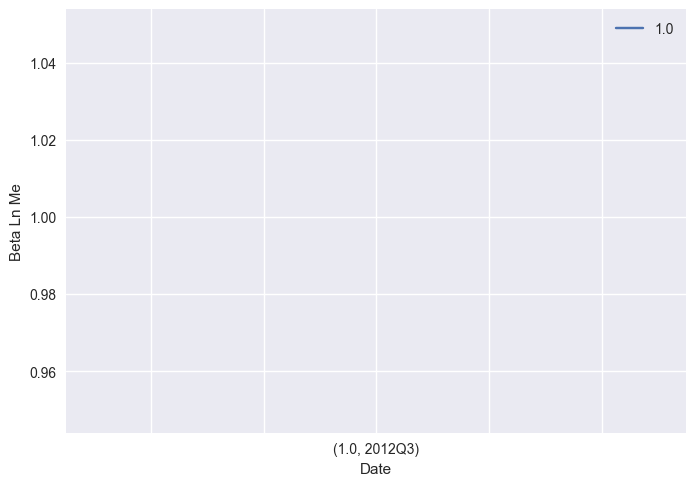

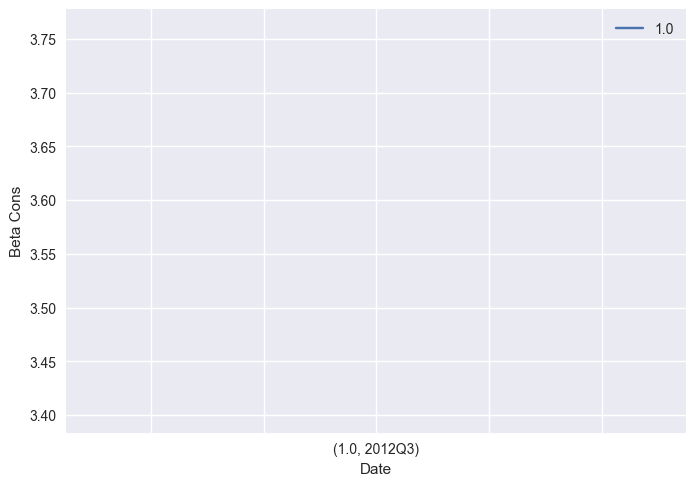

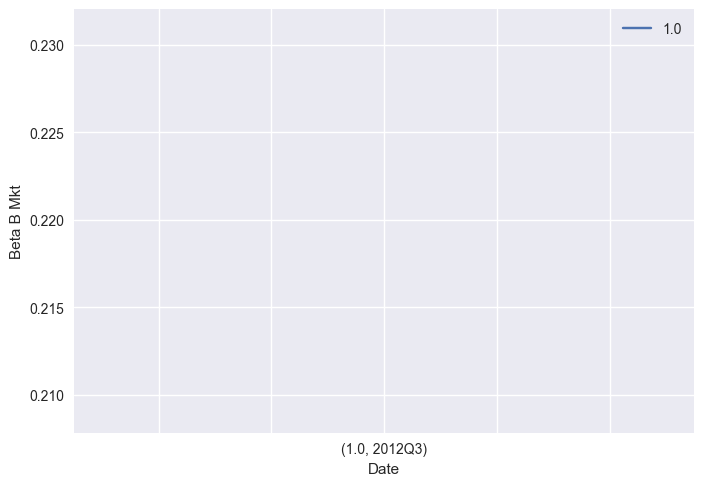

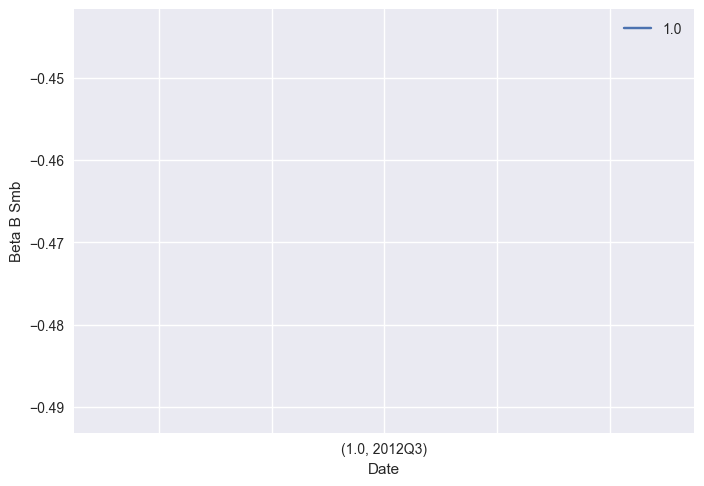

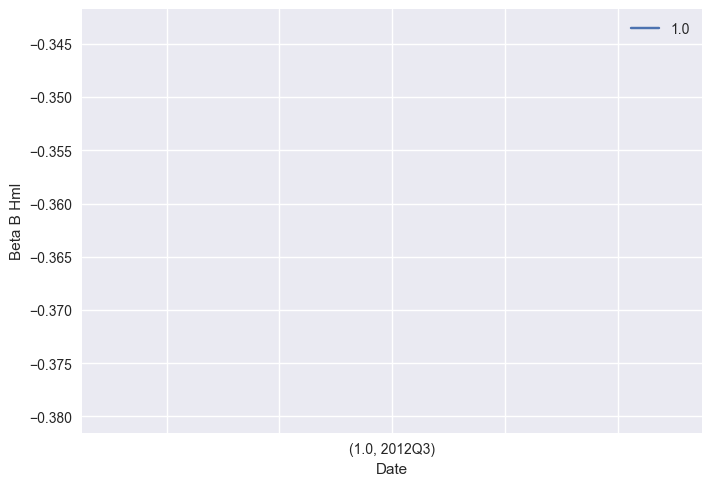

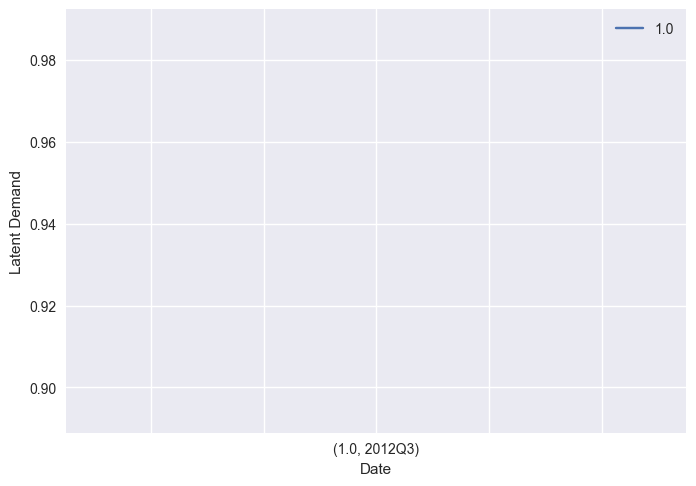


---------------Finished---------------------------


In [195]:
print('\n---------------Creating Figures---------------------------\n')
graph_type_params(df_results, params, figure_path)

print('\n---------------Finished---------------------------\n')